Files already downloaded and verified
Epoch 0
STEP:  0 3125
Epoch 0 | step 000 Loss: 0.812227725982666 


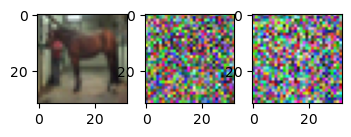

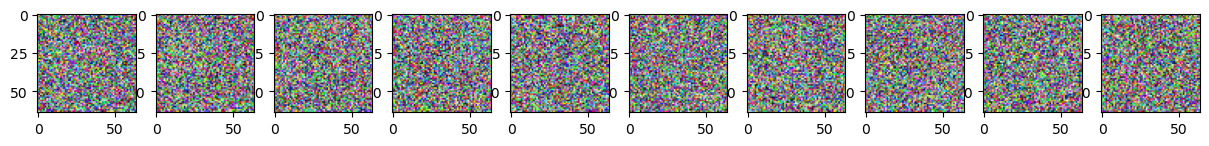

STEP:  100 3125
STEP:  200 3125
STEP:  300 3125
STEP:  400 3125
STEP:  500 3125
STEP:  600 3125
STEP:  700 3125
STEP:  800 3125
STEP:  900 3125
STEP:  1000 3125
STEP:  1100 3125
STEP:  1200 3125
STEP:  1300 3125
STEP:  1400 3125
STEP:  1500 3125
STEP:  1600 3125
STEP:  1700 3125
STEP:  1800 3125
STEP:  1900 3125
STEP:  2000 3125
STEP:  2100 3125
STEP:  2200 3125
STEP:  2300 3125
STEP:  2400 3125
STEP:  2500 3125
STEP:  2600 3125
STEP:  2700 3125
STEP:  2800 3125
STEP:  2900 3125
STEP:  3000 3125
STEP:  3100 3125
Epoch 1
STEP:  0 3125
STEP:  100 3125
STEP:  200 3125
STEP:  300 3125
STEP:  400 3125
STEP:  500 3125
STEP:  600 3125
STEP:  700 3125
STEP:  800 3125
STEP:  900 3125
STEP:  1000 3125
STEP:  1100 3125
STEP:  1200 3125
STEP:  1300 3125
STEP:  1400 3125
STEP:  1500 3125
STEP:  1600 3125
STEP:  1700 3125
STEP:  1800 3125
STEP:  1900 3125
STEP:  2000 3125
STEP:  2100 3125
STEP:  2200 3125
STEP:  2300 3125
STEP:  2400 3125
STEP:  2500 3125
STEP:  2600 3125
STEP:  2700 3125
STEP:  280

In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.optim import Adam


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(
            half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


# nn.Module class, which is the base class for all neural network modules in PyTorch.
class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1],
                                          time_emb_dim)
                                    for i in range(len(down_channels) - 1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1],
                                        time_emb_dim, up=True)
                                  for i in range(len(up_channels) - 1)])

        self.output = nn.Conv2d(up_channels[-1], 3, out_dim)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)

        x = self.conv0(x)

        residuals = []

        for down in self.downs:
            x = down(x, t)
            residuals.append(x)

        for up in self.ups:
            residuals_pop = residuals.pop()
            x = torch.cat((residuals_pop, x), dim=1)
            x = up(x, t)

        return self.output(x)

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(
        sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    # mean + variance
#     print("sqrt_alphas_cumprod_t : ", sqrt_alphas_cumprod_t.shape)
#     print("x_0 :", x_0.shape)
#     print("sqrt_one_minus_alphas_cumprod_t:", sqrt_one_minus_alphas_cumprod_t.shape)
#     print("noise:", noise.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
        + sqrt_one_minus_alphas_cumprod_t.to(device) * \
        noise.to(device), noise.to(device)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)


def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


@torch.no_grad()
def sample_timestep(x, t):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)

    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_image():
    # Sample noise
    img_size = IMG_SIZE
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t)
        if i % stepsize == 0:
            # print(f"timestep: {i} / {num_images}, {i // stepsize + 1}")
            plt.subplot(1, num_images, i // stepsize + 1)
            show_tensor_image(img.detach().cpu())
    plt.show()

def get_loss(model, x_0, t):
    # x_noisy, noise = forward_diffusion.forward_diffusion_sample(x_0, t, device=device)
    x_noisy, noise = forward_diffusion_sample(x_0, t, device=device)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise_pred, noise)


IMG_SIZE = 64
T = 300
BATCH_SIZE = 16
betas = linear_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


transform = transforms.Compose(
    [transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# instance of dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# feeding data to data loader
trainloader = torch.utils.data.DataLoader(dataset=trainset,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=4)  # num_workers when using for multiple processes

image = next(iter(trainloader))[0]
T = 300

plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 10
# stepsize = int(T / num_images)
stepsize = 100
for index in range(0, T, stepsize):
    t = torch.Tensor([index]).type(torch.int64)
    # t = torch.full((image.size(0),), index, dtype=torch.int64)
    # print("t: ", t.shape)
    plt.subplot(1, num_images + 1, int(index / stepsize) + 1)
    # image, noise = forward_diffusion.forward_diffusion_sample(image, t)
    image, noise = forward_diffusion_sample(image, t)
    # forward_diffusion.show_tensor_image(image)
    show_tensor_image(image)

# =============================================================================
# Using UNET
# =============================================================================

# model = UNet.SimpleUnet()
model = SimpleUnet()

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 100  # Try more!

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    for step, batch in enumerate(trainloader):
        if step % 100 == 0:
            print("STEP: ", step, len(trainloader))
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
        loss = get_loss(model, batch[0], t)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            sample_plot_image()
            # forward_diffusion.sample_plot_image()
